# Capstone Project - Car Accident Severity
This Jupyter notebook will be used to construct the final project for my Data Science Professional Certificate by IBM.

In [1]:
# import relevant libraries
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std

# libraries for downloading csv file
import csv
import requests
import itertools

# libraries for visualisation
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import NullFormatter

# libraries from sklearn
from sklearn import metrics
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn import preprocessing
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import itertools


In [2]:
# load as pandas dataframe
df = pd.read_csv("https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DP0701EN/version-2/Data-Collisions.csv")


C:\Users\atereo01\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (33) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


# Exploratory Data Analysis & Data Cleaning

In [3]:
df.head(3)

,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,...,Wet,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,...,Wet,Dark - Street Lights On,NaN,6354039.0,NaN,11,From same direction - both going straight - bo...,0,0,N
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,...,Dry,Daylight,NaN,4323031.0,NaN,32,One parked--one moving,0,0,N


In [4]:
df.columns

Index(['SEVERITYCODE', 'X', 'Y', 'OBJECTID', 'INCKEY', 'COLDETKEY', 'REPORTNO',
       'STATUS', 'ADDRTYPE', 'INTKEY', 'LOCATION', 'EXCEPTRSNCODE',
       'EXCEPTRSNDESC', 'SEVERITYCODE.1', 'SEVERITYDESC', 'COLLISIONTYPE',
       'PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'INCDATE',
       'INCDTTM', 'JUNCTIONTYPE', 'SDOT_COLCODE', 'SDOT_COLDESC',
       'INATTENTIONIND', 'UNDERINFL', 'WEATHER', 'ROADCOND', 'LIGHTCOND',
       'PEDROWNOTGRNT', 'SDOTCOLNUM', 'SPEEDING', 'ST_COLCODE', 'ST_COLDESC',
       'SEGLANEKEY', 'CROSSWALKKEY', 'HITPARKEDCAR'],
      dtype='object')

In [5]:
df.groupby('SEVERITYCODE')['SEVERITYDESC'].value_counts()

SEVERITYCODE  SEVERITYDESC                  
1             Property Damage Only Collision    136485
2             Injury Collision                   58188
Name: SEVERITYDESC, dtype: int64

In [6]:
df.dtypes

SEVERITYCODE        int64
X                 float64
Y                 float64
OBJECTID            int64
INCKEY              int64
COLDETKEY           int64
REPORTNO           object
STATUS             object
ADDRTYPE           object
INTKEY            float64
LOCATION           object
EXCEPTRSNCODE      object
EXCEPTRSNDESC      object
SEVERITYCODE.1      int64
SEVERITYDESC       object
COLLISIONTYPE      object
PERSONCOUNT         int64
PEDCOUNT            int64
PEDCYLCOUNT         int64
VEHCOUNT            int64
INCDATE            object
INCDTTM            object
JUNCTIONTYPE       object
SDOT_COLCODE        int64
SDOT_COLDESC       object
INATTENTIONIND     object
UNDERINFL          object
WEATHER            object
ROADCOND           object
LIGHTCOND          object
PEDROWNOTGRNT      object
SDOTCOLNUM        float64
SPEEDING           object
ST_COLCODE         object
ST_COLDESC         object
SEGLANEKEY          int64
CROSSWALKKEY        int64
HITPARKEDCAR       object
dtype: objec

In [7]:
df['SEVERITYDESC'].value_counts().to_frame() # choosing columns to use from the dataframe

,SEVERITYDESC
Property Damage Only Collision,136485
Injury Collision,58188


In [8]:
# exploring INTKEY unique values and counts
print(np.sort(df['INTKEY'].unique()))
print(len(df['INTKEY'].unique()))

[ 23807.  23808.  23811. ... 725404. 757580.     nan]
7615


In [9]:
# exploring junctiontype and addrtype relationship
df.groupby('ADDRTYPE')['JUNCTIONTYPE'].value_counts()

ADDRTYPE      JUNCTIONTYPE                                     
Alley         Mid-Block (not related to intersection)                176
              Driveway Junction                                       59
              At Intersection (but not related to intersection)        1
Block         Mid-Block (not related to intersection)              89330
              Mid-Block (but intersection related)                 22774
              Driveway Junction                                    10611
              Ramp Junction                                          133
              At Intersection (intersection related)                   4
              Unknown                                                  4
              At Intersection (but not related to intersection)        1
Intersection  At Intersection (intersection related)               62782
              At Intersection (but not related to intersection)     2094
              Ramp Junction                                 

In [10]:
# exploring crosswalkkey value counts
df['CROSSWALKKEY'].value_counts()

0         190862
523609        17
520838        15
525567        13
521707        10
           ...  
521019         1
630862         1
25545          1
523322         1
27186          1
Name: CROSSWALKKEY, Length: 2198, dtype: int64

               NON_ZERO_CROSSWALKKEY_COUNT  ZERO_CROSSWALKKEY_COUNT
COLLISIONTYPE                                                      
Angles                                   8                    34666
Cycles                                 627                     4788
Left Turn                                5                    13698
Other                                    4                    23699
Parked Car                               1                    47986
Pedestrian                            3104                     3504
Rear Ended                              10                    34080
Right Turn                               2                     2954
Sideswipe                                2                    18607


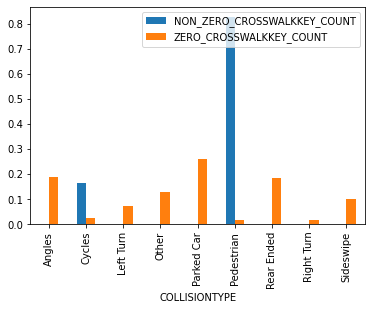

In [11]:
# filtering out CROSSWALKKEY according to non-zero and zero values, grouped by COLLISIONTYPE
del_df1 = df[df['CROSSWALKKEY'] !=0].groupby('COLLISIONTYPE').size().to_frame('NON_ZERO_CROSSWALKKEY_COUNT')
del_df2 = df[df['CROSSWALKKEY'] ==0].groupby('COLLISIONTYPE').size().to_frame('ZERO_CROSSWALKKEY_COUNT')

# merging 2 dfs and normalising along columns
del_df1 = pd.merge(del_df1, del_df2, on='COLLISIONTYPE')
print(del_df1)
del_df1 = (del_df1/del_df1.sum()).reset_index()

# plot 
del_df1.plot(x='COLLISIONTYPE', kind='bar')

plt.show()

In [12]:
# exploring SEGLANEKEY values
df['SEGLANEKEY'].value_counts()

0         191907
6532          19
6078          16
12162         15
10336         14
           ...  
35157          1
10817          1
15043          1
525169         1
16376          1
Name: SEGLANEKEY, Length: 1955, dtype: int64

               NON_ZERO_SEGLANEKEY_COUNT  ZERO_SEGLANEKEY_COUNT
COLLISIONTYPE                                                  
Angles                                 9                  34665
Cycles                              2668                   2747
Head On                                2                   2022
Left Turn                             14                  13689
Other                                 19                  23684
Parked Car                             2                  47985
Pedestrian                             4                   6604
Rear Ended                             4                  34086
Right Turn                             4                   2952
Sideswipe                              4                  18605


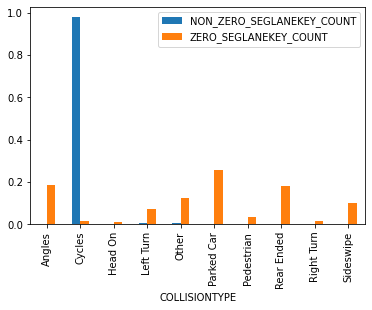

In [13]:

# filtering out SEGLANEKEY according to non-zero and zero values, grouped by COLLISIONTYPE
del_df1 = df[df['SEGLANEKEY'] !=0].groupby('COLLISIONTYPE').size().to_frame('NON_ZERO_SEGLANEKEY_COUNT')
del_df2 = df[df['SEGLANEKEY'] ==0].groupby('COLLISIONTYPE').size().to_frame('ZERO_SEGLANEKEY_COUNT')

# merging 2 dfs and normalising along columns
del_df1 = pd.merge(del_df1, del_df2, on='COLLISIONTYPE')
print(del_df1)
del_df1 = (del_df1/del_df1.sum()).reset_index()

# plot 
del_df1.plot(x='COLLISIONTYPE', kind='bar')
plt.show()

In [14]:
# Create a dataframe which has only the selected features#
df_sev=df[['SEVERITYCODE','ADDRTYPE','JUNCTIONTYPE','WEATHER','ROADCOND', 'LIGHTCOND']]
df_sev.head()

,SEVERITYCODE,ADDRTYPE,JUNCTIONTYPE,WEATHER,ROADCOND,LIGHTCOND
0,2,Intersection,At Intersection (intersection related),Overcast,Wet,Daylight
1,1,Block,Mid-Block (not related to intersection),Raining,Wet,Dark - Street Lights On
2,1,Block,Mid-Block (not related to intersection),Overcast,Dry,Daylight
3,1,Block,Mid-Block (not related to intersection),Clear,Dry,Daylight
4,2,Intersection,At Intersection (intersection related),Raining,Wet,Daylight


In [15]:
### To check the null values in each Column #####
null_columns=df_sev.columns[df_sev.isnull().any()]
df_sev[null_columns].isnull().sum()

ADDRTYPE        1926
JUNCTIONTYPE    6329
WEATHER         5081
ROADCOND        5012
LIGHTCOND       5170
dtype: int64

## Data Cleaning

In [16]:
# CHECK FOR NULL VALUES IN KEY COLUMNS #
df_sev.isnull().sum()

SEVERITYCODE       0
ADDRTYPE        1926
JUNCTIONTYPE    6329
WEATHER         5081
ROADCOND        5012
LIGHTCOND       5170
dtype: int64

In [17]:
#  Replace NULL Values with "Others"  #
df_sev['ADDRTYPE'] = df_sev['ADDRTYPE'].fillna(0)
df_sev['ADDRTYPE'] = df_sev['ADDRTYPE'].replace(0,'Other')

df_sev['JUNCTIONTYPE'] = df_sev['JUNCTIONTYPE'].fillna(0)
df_sev['JUNCTIONTYPE'] = df_sev['JUNCTIONTYPE'].replace(0,'Other')

df_sev['WEATHER'] = df_sev['WEATHER'].fillna(0)
df_sev['WEATHER'] = df_sev['WEATHER'].replace(0,'Unspecified')

df_sev['ROADCOND'] = df_sev['ROADCOND'].fillna(0)
df_sev['ROADCOND'] = df_sev['ROADCOND'].replace(0,'Unspecified')

df_sev['LIGHTCOND'] = df_sev['LIGHTCOND'].fillna(0)
df_sev['LIGHTCOND'] = df_sev['LIGHTCOND'].replace(0,'Unspecified')

<ipython-input-17-0c5fcec5e8cb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sev['ADDRTYPE'] = df_sev['ADDRTYPE'].fillna(0)
<ipython-input-17-0c5fcec5e8cb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sev['ADDRTYPE'] = df_sev['ADDRTYPE'].replace(0,'Other')
<ipython-input-17-0c5fcec5e8cb>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

In [18]:
# list of features to keep

features = ['STATUS','ADDRTYPE', 'SEVERITYCODE','PERSONCOUNT', 'PEDCOUNT',
            'PEDCYLCOUNT', 'VEHCOUNT', 'INCDATE', 'INCDTTM','JUNCTIONTYPE',
            'WEATHER', 'ROADCOND', 'LIGHTCOND', 'SEGLANEKEY','CROSSWALKKEY',
            'HITPARKEDCAR']

In [19]:
df_sev.isnull().sum()

SEVERITYCODE    0
ADDRTYPE        0
JUNCTIONTYPE    0
WEATHER         0
ROADCOND        0
LIGHTCOND       0
dtype: int64

In [20]:
## Encoding the features into Numarical values###

severity = preprocessing.LabelEncoder()
severity.fit(df_sev['SEVERITYCODE'])
df_sev['SEVERITYCODE'] = severity.transform(df_sev['SEVERITYCODE'])


addrtype = preprocessing.LabelEncoder()
addrtype.fit(df_sev['ADDRTYPE'])
df_sev['ADDRTYPE'] = addrtype.transform(df_sev['ADDRTYPE'])

junctype = preprocessing.LabelEncoder()
junctype.fit(df_sev['JUNCTIONTYPE'])
df_sev['JUNCTIONTYPE'] = junctype.transform(df_sev['JUNCTIONTYPE'])

weather = preprocessing.LabelEncoder()
weather.fit(df_sev['WEATHER'])
df_sev['WEATHER'] = weather.transform(df_sev['WEATHER'])

roadcond = preprocessing.LabelEncoder()
roadcond.fit(df_sev['ROADCOND'])
df_sev['ROADCOND'] = roadcond.transform(df_sev['ROADCOND'])

lightcond = preprocessing.LabelEncoder()
lightcond.fit(df_sev['LIGHTCOND'])
df_sev['LIGHTCOND'] = lightcond.transform(df_sev['LIGHTCOND'])


df_sev.head(5)

<ipython-input-20-0ac55277391c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sev['SEVERITYCODE'] = severity.transform(df_sev['SEVERITYCODE'])
<ipython-input-20-0ac55277391c>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sev['ADDRTYPE'] = addrtype.transform(df_sev['ADDRTYPE'])
<ipython-input-20-0ac55277391c>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

,SEVERITYCODE,ADDRTYPE,JUNCTIONTYPE,WEATHER,ROADCOND,LIGHTCOND
0,1,2,1,4,9,5
1,0,1,4,6,9,2
2,0,1,4,4,0,5
3,0,1,4,1,0,5
4,1,2,1,6,9,5


# Understand the Correlation

In [21]:
df_sev.corr()

,SEVERITYCODE,ADDRTYPE,JUNCTIONTYPE,WEATHER,ROADCOND,LIGHTCOND
SEVERITYCODE,1.000000,0.172032,-0.216118,-0.112507,-0.045574,-0.067817
ADDRTYPE,0.172032,1.000000,-0.804215,-0.038823,-0.002626,-0.013375
JUNCTIONTYPE,-0.216118,-0.804215,1.000000,0.134021,0.048077,0.077417
WEATHER,-0.112507,-0.038823,0.134021,1.000000,0.728901,0.339707
ROADCOND,-0.045574,-0.002626,0.048077,0.728901,1.000000,0.083132
LIGHTCOND,-0.067817,-0.013375,0.077417,0.339707,0.083132,1.000000


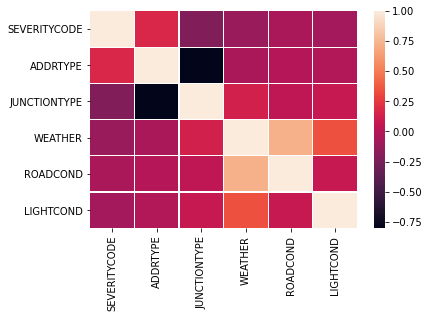

In [22]:
sns.heatmap(df_sev.corr(), linewidth=.2, cbar_kws={"shrink": 1})

## Relationship between WEATHER by SEVERITY of accidents

In [23]:
X = df_sev[['ADDRTYPE', 'JUNCTIONTYPE', 'WEATHER', 'ROADCOND', 'LIGHTCOND']]
X.head()

,ADDRTYPE,JUNCTIONTYPE,WEATHER,ROADCOND,LIGHTCOND
0,2,1,4,9,5
1,1,4,6,9,2
2,1,4,4,0,5
3,1,4,1,0,5
4,2,1,6,9,5


In [24]:
X = pd.concat([X, pd.get_dummies(df_sev['ADDRTYPE'])], axis=1)
X = pd.concat([X, pd.get_dummies(df_sev['JUNCTIONTYPE'])], axis=1)
X = pd.concat([X, pd.get_dummies(df_sev['WEATHER'])], axis=1)
X = pd.concat([X, pd.get_dummies(df_sev['ROADCOND'])], axis=1)
X = pd.concat([X, pd.get_dummies(df_sev['LIGHTCOND'])], axis=1)

print(X.shape)
X.head()

(194673, 49)


,ADDRTYPE,JUNCTIONTYPE,WEATHER,ROADCOND,LIGHTCOND,0,1,2,3,0,...,0,1,2,3,4,5,6,7,8,9
0,2,1,4,9,5,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
1,1,4,6,9,2,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,1,4,4,0,5,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,1,4,1,0,5,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,2,1,6,9,5,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0


In [25]:
X = preprocessing.StandardScaler().fit(X).transform(X)
X[0:3]

array([[ 1.28668708, -1.27015852,  0.22981187,  1.48272745,  0.25900713,
        -0.06223095, -1.36876932,  1.41129279, -0.09996186, -0.10437651,
         1.44892892, -0.2408193 , -0.36412936, -0.92535062, -0.18331232,
        -0.02921369, -0.00679952, -0.01696304, -1.15340914, -0.05414257,
        -0.06551471,  2.45445634, -0.00506801, -0.45298634, -0.011333  ,
        -0.02409974, -0.06841713, -0.28988624, -0.163706  , -1.33213439,
        -0.07905204, -0.01813462, -0.02604842, -0.01963186, -0.07200071,
        -0.02431221, -0.28975087, -0.16256106,  1.76085874, -0.08920831,
        -0.07872239, -0.576075  , -0.00751719, -0.1141037 ,  0.82233559,
        -0.17682024, -0.03476509, -0.27267986, -0.1651723 ],
       [-0.69338623,  0.85075741,  0.87758556,  1.48272745, -1.36653782,
        -0.06223095,  0.73058329, -0.70857019, -0.09996186, -0.10437651,
        -0.69016498, -0.2408193 , -0.36412936,  1.08067145, -0.18331232,
        -0.02921369, -0.00679952, -0.01696304, -1.15340914, -0.

In [26]:
y = df_sev['SEVERITYCODE'].values ## the 'df_coll_clean' dataframe is consistent with the 'features' dataframe
                                            
y[0:5]

array([1, 0, 0, 0, 1], dtype=int64)

In [27]:
df_sev['SEVERITYCODE']

0         1
1         0
2         0
3         0
4         1
         ..
194668    1
194669    0
194670    1
194671    1
194672    0
Name: SEVERITYCODE, Length: 194673, dtype: int64

# Modeling
### Test-Train Data Split

In [28]:
### Split the source data into TRAIN - TEST data sets

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (155738, 49) (155738,)
Test set: (38935, 49) (38935,)


### Modeling - K Nearest Neighbors

In [29]:
X_train_part = pd.DataFrame(X_train).sample(n = 10000, random_state = 0)
y_train_part = pd.DataFrame(y_train).sample(n = 10000, random_state = 0) 

X_train_part_train, X_train_part_test, y_train_part_train, y_train_part_test = \
                    train_test_split( X_train_part, y_train_part, test_size=0.2, random_state=42)

print ('Part Train set:', X_train_part_train.shape,  y_train_part_train.shape)
print ('Part Test set:', X_train_part_test.shape,  y_train_part_test.shape)

Part Train set: (8000, 49) (8000, 1)
Part Test set: (2000, 49) (2000, 1)


In [30]:
Ks = 30
mean_acc = np.zeros((Ks-1))

for n in range(1,Ks):
     
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train_part_train, np.ravel(y_train_part_train))
    yhat = neigh.predict(X_train_part_test)
    mean_acc[n-1] = metrics.accuracy_score(y_train_part_test, yhat)


print("The mean accuracy array is:", mean_acc)
print("\nThe maximum mean accuracy value is:", mean_acc.max())

k = list(mean_acc).index(mean_acc.max()) + 1
print("\nThe best model is the model with k-value = ", k)

The mean accuracy array is: [0.5235 0.672  0.6365 0.6575 0.653  0.658  0.632  0.6625 0.655  0.6625
 0.667  0.6645 0.6685 0.674  0.6705 0.6825 0.681  0.6765 0.6765 0.6785
 0.683  0.679  0.683  0.684  0.6845 0.681  0.679  0.6875 0.6745]

The maximum mean accuracy value is: 0.6875

The best model is the model with k-value =  28


In [31]:
KNN = KNeighborsClassifier(n_neighbors = k).fit(X_train, y_train) ## This takes about 2.5 minutes on an Intel i5-9300H processor
KNN

KNeighborsClassifier(n_neighbors=28)

### Modeling - Decision Tree

In [32]:
X_train_train, X_train_test, y_train_train, y_train_test = \
                    train_test_split( X_train, y_train, test_size=0.2, random_state=0)

print ('Part Train set:', X_train_train.shape,  y_train_train.shape)
print ('Part Test set:', X_train_test.shape,  y_train_test.shape)

Part Train set: (124590, 49) (124590,)
Part Test set: (31148, 49) (31148,)


In [33]:
depth = 21
mean_acc1 = np.zeros((depth - 4))

for n in range(4, depth):
    
    tree = DecisionTreeClassifier(criterion = 'entropy', max_depth = depth).fit(X_train_train, y_train_train)
    yhat = tree.predict(X_train_test)
    mean_acc1[n-4] = metrics.accuracy_score(y_train_test, yhat)


print("The mean accuracy array is:", mean_acc1)
print("\nThe maximum mean accuracy value is:", mean_acc1.max())

max_depth = list(mean_acc1).index(mean_acc1.max()) + 4
print("\nThe best model is the model with max_depth = ", max_depth)

The mean accuracy array is: [0.69853602 0.69847181 0.69850392 0.69850392 0.69853602 0.69853602
 0.69853602 0.69847181 0.69853602 0.69860023 0.69853602 0.69850392
 0.69843971 0.69847181 0.69843971 0.69843971 0.69853602]

The maximum mean accuracy value is: 0.6986002311544882

The best model is the model with max_depth =  13


In [34]:
severityTree = DecisionTreeClassifier(criterion = 'entropy', max_depth = max_depth).fit(X_train, y_train)
severityTree

DecisionTreeClassifier(criterion='entropy', max_depth=13)

### Modeling - Logistic Regression

In [35]:
X_train_part = pd.DataFrame(X_train).sample(n = 1000, random_state = 0)
y_train_part = pd.DataFrame(y_train).sample(n = 1000, random_state = 0) # keeping it consistent with X_train_part by using the
                                                                        # same seed for ramdom_state as in X_train_part

X_train_part_train, X_train_part_test, y_train_part_train, y_train_part_test = \
                    train_test_split( X_train_part, y_train_part, test_size=0.2, random_state=42)

print ('Part Train set:', X_train_part_train.shape,  y_train_part_train.shape)
print ('Part Test set:', X_train_part_test.shape,  y_train_part_test.shape)

Part Train set: (800, 49) (800, 1)
Part Test set: (200, 49) (200, 1)


In [36]:
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
mean_acc2 = np.zeros((len(solvers)))

for i in range(len(solvers)):
    LR = LogisticRegression(C=0.01, solver=solvers[i]).fit(X_train_part_train,np.ravel(y_train_part_train))
    yhat = LR.predict(X_train_part_test)
    mean_acc2[i] = metrics.accuracy_score(y_train_part_test, yhat)
    
print("mean accuracy array:", mean_acc2)
print("\nmaximum mean accuracy value:", mean_acc2.max())

mean accuracy array: [0.695 0.695 0.695 0.695 0.695]

maximum mean accuracy value: 0.695


In [37]:
LR_final = LogisticRegression(C=0.01).fit(X_train, y_train)
LR_final

LogisticRegression(C=0.01)

## Model Evaluation

In [38]:
# Model Evaluation - K Nearest Neighbors

yhat_KNN = KNN.predict(X_test) 

KNN_jacc = jaccard_score(y_test, yhat_KNN, average = 'weighted')
print("Jaccard Index of KNN model is:", KNN_jacc)

KNN_f1 = f1_score(y_test, yhat_KNN, average='weighted')
print("\n The F1-score for KNN model is:", KNN_f1)

KNN_acc = accuracy_score(y_test, yhat_KNN)
print("\n The subset accuracy score for KNN model is:", KNN_acc)

Jaccard Index of KNN model is: 0.5009350454379481

 The F1-score for KNN model is: 0.5991147243368953

 The subset accuracy score for KNN model is: 0.699113907795043


In [39]:
# Model Evaluation - Logistic Regression

yhat_LR_final = LR_final.predict(X_test)
yhat_LR_final_prob = LR_final.predict_proba(X_test)

LR_jacc = jaccard_score(y_test, yhat_LR_final, average = 'weighted')
print("Jaccard accuracy score for the Logistic Regression model:", LR_jacc)

LR_f1 = f1_score(y_test, yhat_LR_final, average='weighted')
print("\nF1_score for the Logistic Regression model:", LR_f1)

LR_acc = accuracy_score(y_test, yhat_LR_final)
print("\n Subset accuracy score for the Logistic Regression model:", LR_acc)

LR_logloss = log_loss(y_test, yhat_LR_final_prob)
print("\nLog Loss for the Logistic Regression model:", LR_logloss)

Jaccard accuracy score for the Logistic Regression model: 0.4960864217799276

F1_score for the Logistic Regression model: 0.5822881020258832

 Subset accuracy score for the Logistic Regression model: 0.7041993065365353

Log Loss for the Logistic Regression model: 0.567210060737418


In [40]:
# Model Evaluation - Decission Tree

yhat_severityTree = severityTree.predict(X_test)
DT_jacc = jaccard_score(y_test, yhat_severityTree, average = 'weighted')
print("The Jaccard accuracy score for the Decision Tree model is:", DT_jacc)

DT_f1 = f1_score(y_test, yhat_severityTree, average='weighted')
print("\nThe F1_score for the Decision Tree model is:", DT_f1)

DT_acc = accuracy_score(y_test, yhat_severityTree)
print("\nThe subset accuracy score for the Decision Tree model is:", DT_acc)

The Jaccard accuracy score for the Decision Tree model is: 0.4969020971593654

The F1_score for the Decision Tree model is: 0.5846405160496333

The subset accuracy score for the Decision Tree model is: 0.7038140490561192


## Summary of the Accuracy scores of the different models

In [41]:
scores_dict = {'': ['K Nearest Neighbors','Decision Tree','Logistic Regression'], \
               'Jaccard Score': [KNN_jacc, DT_jacc, LR_jacc], \
               'F1-score': [KNN_f1, DT_f1, LR_f1], \
               'Subset Accuracy Score': [KNN_acc, DT_acc, LR_acc], \
               'Log Loss': ['NA','NA', LR_logloss] }

scores_Report = pd.DataFrame.from_dict(scores_dict)

scores_Report.set_index('', drop = True, inplace = True)

scores_Report

,Jaccard Score,F1-score,Subset Accuracy Score,Log Loss
,,,,
K Nearest Neighbors,0.500935,0.599115,0.699114,NA
Decision Tree,0.496902,0.584641,0.703814,NA
Logistic Regression,0.496086,0.582288,0.704199,0.56721
